In [246]:
import random
import gym
import numpy as np
from tqdm import tqdm
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils
%config InlineBackend.figure_format = 'svg'


In [247]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound) -> None:
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)
        self.action_bound = action_bound
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return torch.tanh(self.fc2(x)) * self.action_bound

In [248]:
class QValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim) -> None:
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x, a):
        cat = torch.cat([x, a], dim=1)
        x = F.relu(self.fc1(cat))
        x = F.relu(self.fc2(x))
        return self.fc_out(x)

In [249]:
from copy import deepcopy


class DDPG:
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound, sigma, actor_lr, critic_lr, tau, gamma, device):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim, action_bound).to(device)
        self.critic = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        self.target_actor = deepcopy(self.actor)
        self.target_critic = deepcopy(self.critic)

        self.actor_optim = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optim = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.gamma = gamma
        self.sigma = sigma  # 高斯噪声的标准差,均值直接设为0
        self.tau = tau  # 目标网络软更新参数
        self.action_dim = action_dim
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        action = self.actor(state).item()
        action = action + self.sigma * np.random.randn(self.action_dim)
        return action
    def soft_update(self, net, target_net):
        for param_target, param in zip(target_net.parameters(), net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) + param.data * self.tau)

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'], dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        next_q_values = self.target_critic(next_states, self.target_actor(next_states))
        q_targets = rewards + self.gamma * next_q_values * (1 - dones)
        critic_loss = torch.mean(F.mse_loss(self.critic(states, actions), q_targets))
        self.critic_optim.zero_grad()
        critic_loss.backward()
        self.critic_optim.step()

        actor_loss = -torch.mean(self.critic(states, self.actor(states)))
        self.actor_optim.zero_grad()
        actor_loss.backward()
        self.actor_optim.step()

        self.soft_update(self.actor, self.target_actor)
        self.soft_update(self.critic, self.target_critic)

In [250]:
actor_lr = 3e-4
critic_lr = 3e-3
num_episodes = 200
hidden_dim = 64
gamma = 0.98
tau = 0.005  # 软更新参数
buffer_size = 10000
minimal_size = 1000
batch_size = 64
sigma = 0.1  # 高斯噪声标准差
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# env_name = 'Pendulum-v1'
env_name = "MountainCarContinuous-v0"
env = gym.make(env_name)
random.seed(0)
np.random.seed(0)
env.seed(0)
torch.manual_seed(0)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]  # 动作最大值


In [251]:
def train_off_policy_agent(env, agent, num_episodes, replay_buffer, minimal_size, batch_size):
    return_list = []
    for i in range(10):
        with tqdm(total=int(num_episodes/10), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes/10)):
                episode_return = 0
                state = env.reset()
                done = False
                while not done:
                    action = agent.take_action(state)
                    next_state, reward, done, _ = env.step(action)
                    # reward += state[0] * 0.1 + state[1] * state[1]
                    # reward += -state[0] * state[0] * 0.1
                    # reward += -state[0] * state[0] * 0.1 + state[1] * state[1]
                    reward += state[0] ** 3 + state[1] * state[1]
                    replay_buffer.add(state, action, reward, next_state, done)
                    state = next_state
                    episode_return += reward
                    if replay_buffer.size() > minimal_size:
                        b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                        transition_dict = {'states': b_s, 'actions': b_a, 'next_states': b_ns, 'rewards': b_r, 'dones': b_d}
                        agent.update(transition_dict)
                return_list.append(episode_return)
                if (i_episode+1) % 10 == 0:
                    pbar.set_postfix({'episode': '%d' % (num_episodes/10 * i + i_episode+1), 'return': '%.3f' % np.mean(return_list[-10:])})
                pbar.update(1)
    return return_list

In [252]:
agent = DDPG(state_dim, hidden_dim, action_dim, action_bound, sigma, actor_lr, critic_lr, tau, gamma, device)

In [253]:
return_list = train_off_policy_agent(env, agent, num_episodes, replay_buffer, minimal_size, batch_size)

Iteration 0:   0%|          | 0/20 [00:00<?, ?it/s]

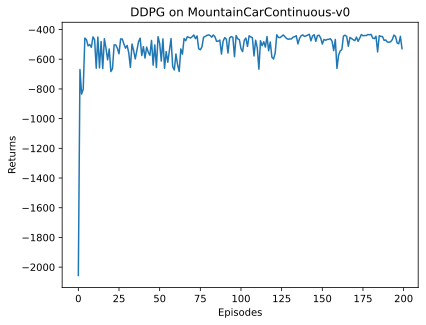

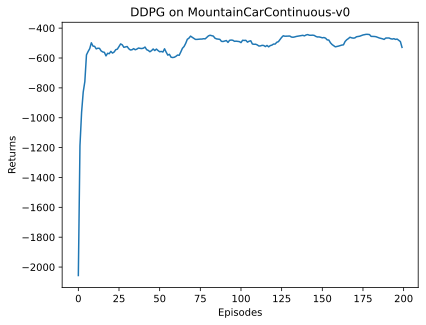

In [ ]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG on {}'.format(env_name))
plt.show()

In [ ]:
import cv2
from matplotlib import animation 

def display_frames_as_gif(frames):
    
    patch = plt.imshow(frames[0])
    plt.axis('off')
    def animate(i):
        patch.set_data(frames[i])
   
    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=1)
    anim.save('./DDPG_result.gif', writer='ffmpeg', fps=30)
    
def run_game(env):
    frames = []
    s = env.reset()
    rewards = 0
    for i_episode in range(1000):
        frames.append(env.render(mode='rgb_array'))
        # time.sleep(0.1)
        action = agent.take_action(s)
        s_, r, done, info = env.step(action)   
        print(s_)
        s = s_
        rewards += r
        if done:  
            break
    
    display_frames_as_gif(frames)
    
    # env.close()
    return rewards


d:\11516\usual\anaconda\envs\pytorch\lib\site-packages\gym\core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


[-0.5969593   0.00206085]
[-0.59285265  0.00410662]
[-0.58673036  0.00612229]
[-0.5786374   0.00809296]
[-0.568645    0.00999242]
[-0.55696785  0.01167714]
[-0.5436236   0.01334426]
[-0.5288765   0.01474714]
[-0.51343495  0.01544152]
[-0.49825034  0.01518462]
[-0.48305565  0.01519468]
[-0.46816626  0.0148894 ]
[-0.45381027  0.01435599]
[-0.43986407  0.01394619]
[-0.42648765  0.01337642]
[-0.41408682  0.01240084]
[-0.4020419   0.01204489]
[-0.39031488  0.01172703]
[-0.37906805  0.01124683]
[-0.36837998  0.01068806]
[-0.35827902  0.01010095]
[-0.34867972  0.00959931]
[-0.33973753  0.00894219]
[-0.33106548  0.00867205]
[-0.32268056  0.00838493]
[-0.31456852  0.00811204]
[-0.30696756  0.00760097]
[-0.299554    0.00741358]
[-0.2924996   0.00705438]
[-0.28571892  0.00678068]
[-0.2791023   0.00661663]
[-0.27301726  0.00608503]
[-0.26718894  0.00582833]
[-0.2616362   0.00555275]
[-0.2565851   0.00505109]
[-0.2518292   0.00475589]
[-0.24742304  0.00440617]
[-0.24335921  0.00406383]
[-0.23966628

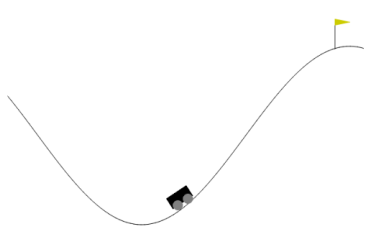

In [ ]:


env.reset()
rewards = run_game(env)
print(rewards)